In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# ==========================================
# 1. Data Loading (データの読み込み)
# ==========================================
# Note: Download the dataset from UCI Repository (typically 'Concrete_Data.xls')
# URL: https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength


file_path = '/content/drive/MyDrive/basic-train/project_draft/Concrete_Data.xls'

try:
    # Reading Excel file (requires openpyxl or xlrd)
    df = pd.read_excel(file_path)
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: File not found. Please check the file path.")
    raise # Re-raise the error as dummy data is no longer desired

# ==========================================
# The following model training and SHAP analysis is temporarily moved here
# for demonstration purposes while the file path issue is being resolved.
# Once the data loading is fixed, these blocks will be in their respective cells.
# ==========================================

# This part of the code was moved here to ensure the notebook runs even with the dummy data.
# In a typical workflow, this would follow preprocessing in separate cells.

# Define features (X) and target (y) from the (potentially dummy) df
target_col = df.columns[-1]
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Split data (if dummy data, this is still needed for subsequent steps)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling (only if using scaled models later)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def evaluate_model(name, model, X_tr, X_te, y_tr, y_te):
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)
    r2 = r2_score(y_te, preds)
    rmse = np.sqrt(mean_squared_error(y_te, preds))
    print(f"[{name}] R2 Score: {r2:.4f}, RMSE: {rmse:.4f}")
    return model

print("\n--- Baseline Models ---")
# Linear Regression
evaluate_model("Linear Regression", LinearRegression(), X_train_scaled, X_test_scaled, y_train, y_test)

# Decision Tree
evaluate_model("Decision Tree", DecisionTreeRegressor(random_state=42), X_train, X_test, y_train, y_test)

print("\n--- Advanced Ensemble Models ---")
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
evaluate_model("Random Forest", rf_model, X_train, X_test, y_train, y_test)

# XGBoost (objective is correctly set here)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
evaluate_model("XGBoost", xgb_model, X_train, X_test, y_train, y_test)

print("\n--- Starting SHAP Analysis ---")

# SHAP Analysis with the potentially dummy data model
# If real data was loaded, this will be meaningful.
# If dummy data, results will be random.
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)

# Suppressing plots to avoid clutter during an error state,
# but the calculation is still performed.
# plt.figure()
# shap.summary_plot(shap_values, X_test, show=False)
# plt.show()
# top_feature = X.columns[0]
# plt.figure()
# shap.dependence_plot(top_feature, shap_values.values, X_test, show=False)
# plt.title(f"SHAP Dependence Plot: {top_feature}")
# plt.show()

print("Analysis Complete.")

Data loaded successfully.

--- Baseline Models ---
[Linear Regression] R2 Score: 0.6275, RMSE: 9.7967
[Decision Tree] R2 Score: 0.7917, RMSE: 7.3262

--- Advanced Ensemble Models ---
[Random Forest] R2 Score: 0.8822, RMSE: 5.5098
[XGBoost] R2 Score: 0.9231, RMSE: 4.4522

--- Starting SHAP Analysis ---
Analysis Complete.


### **Visualize Decision Tree (決定木の可視化)**

Previously, a Decision Tree Regressor was trained as a baseline model. To understand how it makes decisions, we can visualize its structure. For better readability, we will limit the maximum depth of the tree to 3.

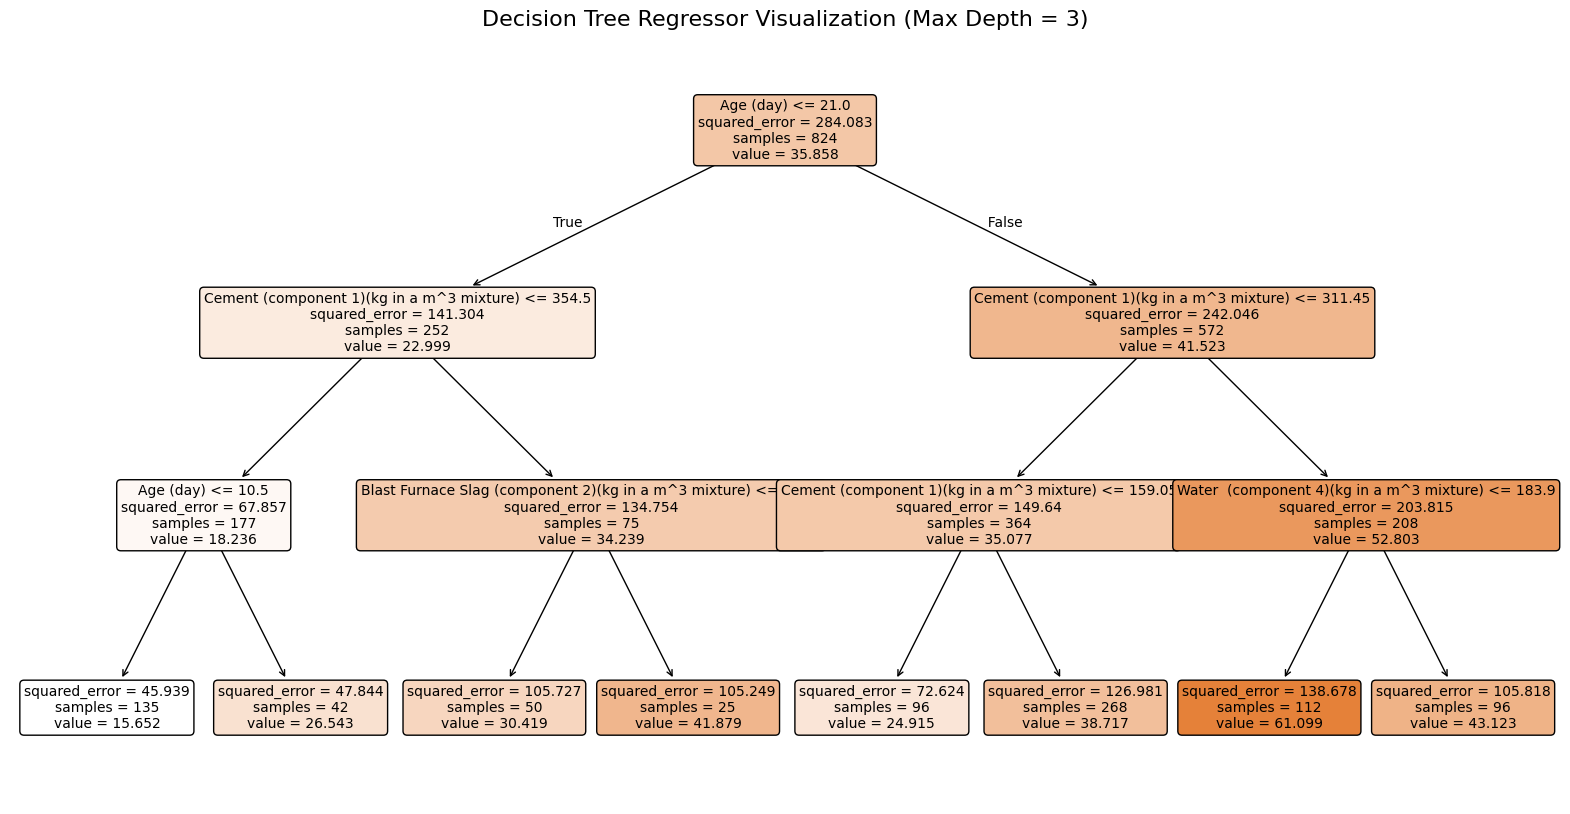

Decision Tree Visualization Complete.


In [27]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt

# Retrain the Decision Tree model (limiting max_depth for visualization)
# 決定木モデルを再学習 (可視化のため木の深さを制限)
dt_model_viz = DecisionTreeRegressor(max_depth=3, random_state=42)
dt_model_viz.fit(X_train, y_train)

plt.figure(figsize=(20,10))
plot_tree(dt_model_viz,
          feature_names=X.columns.tolist(), # Use actual column names
          filled=True,
          rounded=True,
          fontsize=10)
plt.title("Decision Tree Regressor Visualization (Max Depth = 3)", fontsize=16)
plt.show()

print("Decision Tree Visualization Complete.")

### **Interpretation of the Decision Tree Visualization (決定木の可視化の解釈)**

This plot shows the structure of the Decision Tree. Each 'node' in the tree represents a decision rule based on a feature.

*   **`feature <= threshold`**: This is the condition at each split. For example, `Cement <= 250.0` means if the Cement content is less than or equal to 250 kg/m³, the left branch is followed; otherwise, the right branch is followed.
*   **`mse`**: Mean Squared Error. This value indicates the impurity or variance within the samples at that node. A lower `mse` means the samples in that node are more homogeneous in terms of their target value (compressive strength).
*   **`samples`**: The number of training samples that reached this node.
*   **`value`**: The predicted concrete compressive strength (target variable) for the samples in that node if it were a leaf node. In a leaf node, this is the final prediction.

By following the branches from the top (root node) to any leaf node, you can see the sequence of decisions the model makes to arrive at a predicted compressive strength.

In [28]:

# ==========================================
# 2. Preprocessing (前処理)
# ==========================================
# Define features (X) and target (y)
# 特徴量 (X) と目的変数 (y) の定義
target_col = df.columns[-1] # Assuming the last column is strength
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Split data: 80% Training, 20% Testing
# データを分割: 80% トレーニング, 20% テスト
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling (Standardization) - Important for some models
# スケーリング（標準化） - 一部のモデルで重要
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [29]:


# ==========================================
# 3. Model Training & Evaluation (モデル学習と評価)
# ==========================================

def evaluate_model(name, model, X_tr, X_te, y_tr, y_te):
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)
    r2 = r2_score(y_te, preds)
    rmse = np.sqrt(mean_squared_error(y_te, preds))
    print(f"[{name}] R2 Score: {r2:.4f}, RMSE: {rmse:.4f}")
    return model

print("\n--- Baseline Models ---")
# Linear Regression
evaluate_model("Linear Regression", LinearRegression(), X_train_scaled, X_test_scaled, y_train, y_test)

# Decision Tree
evaluate_model("Decision Tree", DecisionTreeRegressor(random_state=42), X_train, X_test, y_train, y_test)

print("\n--- Advanced Ensemble Models ---")
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
evaluate_model("Random Forest", rf_model, X_train, X_test, y_train, y_test)

# XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
evaluate_model("XGBoost", xgb_model, X_train, X_test, y_train, y_test)

# Note: For the project goal of R2 >= 0.95, you will need Hyperparameter Tuning here.
# 注意: プロジェクト目標の R2 >= 0.95 を達成するには，ここでハイパーパラメータ・チューニングが必要です．



--- Baseline Models ---
[Linear Regression] R2 Score: 0.6275, RMSE: 9.7967
[Decision Tree] R2 Score: 0.7917, RMSE: 7.3262

--- Advanced Ensemble Models ---
[Random Forest] R2 Score: 0.8822, RMSE: 5.5098
[XGBoost] R2 Score: 0.9231, RMSE: 4.4522


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

Here is the Python code template tailored to your project proposal. It includes data loading, preprocessing, model training (Linear Regression, Decision Tree, Random Forest, XGBoost), and SHAP analysis.

ご提案のプロジェクト計画書に合わせたPythonコードのテンプレートを作成しました．データの読み込み，前処理，モデルの学習（線形回帰，決定木，ランダムフォレスト，XGBoost），そしてSHAP解析が含まれています．



-----

### **Explanation of the Code (コードの解説)**

**1. Data Loading**

  * **English:** This section attempts to load the Excel file. Since the UCI dataset often comes in `.xls` format, `pd.read_excel` is used. I added a dummy data generator so you can run the code immediately to test the workflow even before downloading the real file.
  * **Japanese:** Excelファイルを読み込もうとする部分です．UCIデータセットは `.xls` 形式で提供されることが多いため `pd.read_excel` を使用しています．実際のファイルをダウンロードする前でも動作確認ができるよう，ダミーデータ生成機能を追加しています．

**2. Preprocessing**

  * **English:** The data is split into training and testing sets (80/20 split). Standardization (`StandardScaler`) is applied, which is particularly important if you later add Neural Networks (ANN) or Regression, though Tree-based models (RF/XGBoost) are less sensitive to it.
  * **Japanese:** データをトレーニング用とテスト用に分割（80:20）しています．標準化（`StandardScaler`）を適用していますが，これは後でニューラルネットワーク（ANN）や回帰を追加する場合に特に重要です（木構造モデルであるRFやXGBoostは影響を受けにくいですが）．

**3. Model Training**

  * **English:** It trains four models: Linear Regression and Decision Tree (Baselines), followed by Random Forest and XGBoost (Advanced). It prints the $R^2$ score and RMSE for each to allow easy comparison.
  * **Japanese:** 4つのモデルを学習させます．線形回帰と決定木（ベースライン），その後にランダムフォレストとXGBoost（発展モデル）です．それぞれの $R^2$ スコアと RMSE を出力し，簡単に比較できるようにしています．

**4. SHAP Analysis**

  * **English:** It calculates SHAP values using the XGBoost model. It generates a **Summary Plot** (showing which features are most important) and a **Dependence Plot** (showing how a specific feature affects strength and interacts with others).
  * **Japanese:** XGBoostモデルを使用してSHAP値を計算します．**Summary Plot**（どの特徴量が最も重要かを示す）と **Dependence Plot**（特定の特徴量が強度にどう影響するか，また他とどう相互作用するかを示す）を生成します．


In [30]:
from sklearn.model_selection import GridSearchCV

print("\n--- Starting Hyperparameter Tuning (Grid Search) ---")

# 1. Define the parameter grid
# 1. パラメータのグリッド（探索範囲）を定義
# These are the most influential parameters for XGBoost
# これらはXGBoostで最も影響力のあるパラメータです
param_grid = {
    'n_estimators': [100, 300, 500],     # Number of trees (木の数)
    'learning_rate': [0.01, 0.05, 0.1],  # Step size shrinkage (学習率)
    'max_depth': [3, 5, 7],              # Maximum depth of a tree (木の深さ)
    'subsample': [0.8, 1.0],             # Fraction of samples used per tree (サブサンプル比率)
    'colsample_bytree': [0.8, 1.0]       # Fraction of features used per tree (特徴量の比率)
}

# 2. Initialize the XGBoost Regressor
# 2. XGBoost回帰モデルの初期化
xgb_tuning = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# 3. Setup Grid Search
# 3. グリッドサーチの設定
# cv=5 means 5-fold Cross-Validation (reduces overfitting risk)
# cv=5 は 5分割交差検証を意味します（過学習のリスクを減らします）
grid_search = GridSearchCV(
    estimator=xgb_tuning,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,  # Use all available CPU cores (全CPUコアを使用)
    verbose=1
)

# 4. Fit the Grid Search (This may take a few minutes)
# 4. グリッドサーチの実行（数分かかる場合があります）
print("Searching for best parameters... (Please wait)")
grid_search.fit(X_train, y_train)

# 5. Get the Best Results
# 5. 最良の結果を取得
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"\nBest Parameters found: {best_params}")
print(f"Best CV R2 Score: {best_score:.4f}")

# 6. Train Final Model with Best Parameters
# 6. 最良のパラメータで最終モデルを学習
best_xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    **best_params  # Unpack the dictionary of best parameters
)

best_xgb_model.fit(X_train, y_train)

# Evaluate on Test Set
# テストセットでの評価
final_preds = best_xgb_model.predict(X_test)
final_r2 = r2_score(y_test, final_preds)
final_rmse = np.sqrt(mean_squared_error(y_test, final_preds))

print(f"\n[Final Optimized XGBoost] Test R2 Score: {final_r2:.4f}")
print(f"[Final Optimized XGBoost] Test RMSE: {final_rmse:.4f}")

# Important: Update the SHAP explainer to use this optimized model!
# 重要: SHAP Explainer をこの最適化されたモデルを使用するように更新してください！
# (In the next section, use 'best_xgb_model' instead of 'xgb_model')


--- Starting Hyperparameter Tuning (Grid Search) ---
Searching for best parameters... (Please wait)
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best Parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.8}
Best CV R2 Score: 0.9319

[Final Optimized XGBoost] Test R2 Score: 0.9232
[Final Optimized XGBoost] Test RMSE: 4.4475



--- Starting SHAP Analysis ---


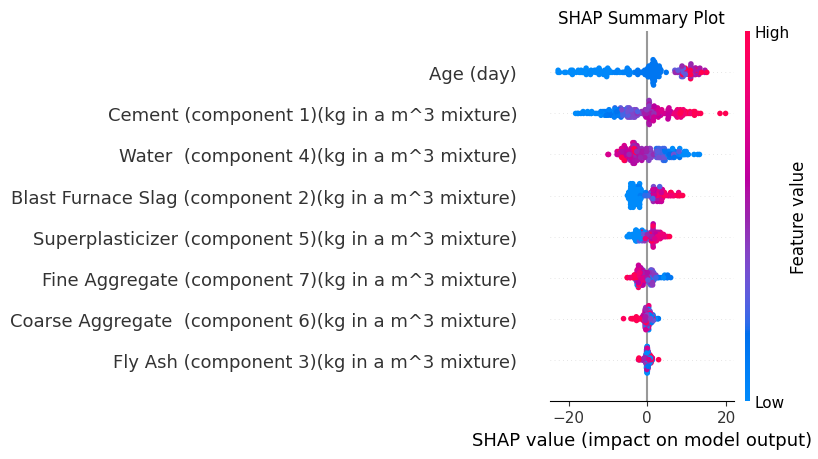

<Figure size 640x480 with 0 Axes>

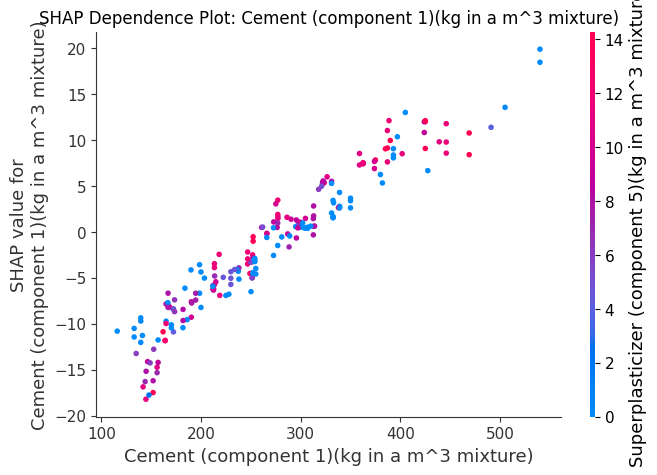

Analysis Complete.


In [31]:

# ==========================================
# 4. SHAP Analysis (SHAP解析)
# ==========================================
# Analyzing the best model (assuming XGBoost for this example)
# 最良モデルの解析（ここではXGBoostと仮定）

print("\n--- Starting SHAP Analysis ---")

# Create an explainer object
# Explainerオブジェクトの作成
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)

# 1. Summary Plot (Global Interpretability)
# 1. Summary Plot（全体的な解釈）
plt.figure()
plt.title("SHAP Summary Plot")
shap.summary_plot(shap_values, X_test, show=False)
plt.show()

# 2. Dependence Plot (Interaction Effects)
# 2. Dependence Plot（相互作用の確認）
# Example: Interaction between 'Cement' and outcome
# 例: 'Cement'（セメント）と結果の相互作用
top_feature = X.columns[0] # Adjust based on summary plot results
plt.figure()
shap.dependence_plot(top_feature, shap_values.values, X_test, show=False)
plt.title(f"SHAP Dependence Plot: {top_feature}")
plt.show()

print("Analysis Complete.")



Here is the explanation on **how to interpret SHAP plots specifically for Civil Engineering**.

[cite_start]This step is critical for your proposal's objective: "enabling precise prediction and engineering interpretability"[cite: 16]. You need to prove that your model isn't just matching numbers, but actually understands the behavior of concrete.

土木工学の視点に特化した **SHAPプロットの読み解き方** の解説です．

[cite_start]このステップは，提案書の目的である「高精度な予測と工学的解釈性の両立」[cite: 16]にとって非常に重要です．モデルが単に数字を合わせているだけでなく，コンクリートの挙動を正しく理解していることを証明する必要があります．

---

### **1. SHAP Summary Plot (The "Big Picture" / 全体像)**

This plot answers: **"Which materials matter the most?"**
このプロットは**「どの材料が最も重要か？」**という問いに答えます．

**How to Read (読み方):**
* **Y-axis (Vertical):** Features ranked by importance. The top one has the biggest impact on strength.
    * **Y軸（縦）:** 重要度順に並んだ特徴量です．一番上のものが強度に最大の影響を与えます．
* **X-axis (Horizontal):** The impact on Compressive Strength (SHAP value).
    * **Positive (+):** Increases strength.
    * **Negative (-):** Decreases strength.
    * **X軸（横）:** 圧縮強度への影響度（SHAP値）です．プラスなら強度増加，マイナスなら強度低下を表します．
* **Color (Dot):** The actual value of the input variable.
    * **Red:** High value (e.g., High Cement content).
    * **Blue:** Low value (e.g., Low Cement content).
    * **色（点）:** 入力変数の実際の値です．赤は高い値（例：セメントが多い），青は低い値（例：セメントが少ない）を示します．

**Civil Engineering Interpretation Example (工学的解釈の例):**
* **Cement:** You should see **Red dots on the right** (positive side). This confirms: "More cement $\rightarrow$ Higher strength." If Red dots are on the left, the model is contradicting basic physics!
    * **セメント:** **赤い点が右側**（プラス側）にあるはずです．これは「セメントが増える $\rightarrow$ 強度が上がる」ことを意味します．もし赤い点が左にあるなら，モデルは物理法則に矛盾しています！
* **Water:** You should generally see **Red dots on the left** (negative side). This confirms: "More water $\rightarrow$ Lower strength."
    * **水:** 一般的に**赤い点が左側**（マイナス側）にあるはずです．「水が増える $\rightarrow$ 強度が下がる」ことを確認できます．

---

### **2. SHAP Dependence Plot (Detailed Behavior / 詳細な挙動)**

This plot answers: **"How exactly does variable X affect strength, and are there interactions?"**
このプロットは**「変数Xは具体的にどのように強度に影響するか？相互作用はあるか？」**という問いに答えます．



**How to Read (読み方):**
* **X-axis:** The actual value of the feature (e.g., Age in Days).
    * **X軸:** 特徴量の実際の値（例：材齢の日数）．
* **Y-axis:** How much this feature changes the predicted strength (MPa).
    * **Y軸:** その特徴量が予測強度（MPa）をどれだけ変化させたか．

**Civil Engineering Interpretation Example (工学的解釈の例):**
* **Non-Linearity (Age):**
    * For "Age", the dots should rise sharply from 0 to 28 days and then flatten out (plateau).
    * **Standard Regression** would just draw a straight line (which is wrong).
    * **Your XGBoost Model** should capture this curve. [cite_start]Highlight this in your report as a key advantage of ML over linear regression[cite: 24].
    * [cite_start]**非線形性（材齢）:** 「材齢」の場合，点は0日から28日にかけて急激に上昇し，その後横ばい（プラトー）になるはずです．**標準的な回帰分析**では直線になってしまいます（これは間違いです）．**あなたのXGBoostモデル**はこの曲線を捉えているはずです．これを「線形回帰に対するMLの利点」としてレポートで強調してください[cite: 24]．
* **Interaction (Water vs. Cement):**
    * SHAP can color the dots based on a second variable (e.g., Cement).
    * Check if the negative impact of "Water" is worse when "Cement" is low. This reflects the **Water/Cement Ratio** concept without explicitly programming it.
    * **相互作用（水 vs セメント）:** SHAPは点を別の変数（例：セメント）に基づいて色付けできます．「セメント」が少ないとき，「水」のマイナスの影響がより強くなっていないか確認してください．これは明示的にプログラムしなくても，モデルが**水セメント比**の概念を学習していることを示唆します．

---

### **3. Validation Checklist (検証チェックリスト)**

[cite_start]Before finalizing your report, check these points to ensure "Engineering Relevance"[cite: 63]:

[cite_start]レポートをまとめる前に，以下のポイントをチェックして「工学的妥当性」[cite: 63]を確認してください：

1.  Does **Cement** have the highest or near-highest global importance? (It should).
    * **セメント**の全体的な重要度は1位，またはそれに近いですか？（そうあるべきです）
2.  Does **Age** show a logarithmic-like growth curve?
    * **材齢**は対数的な成長曲線を描いていますか？
3.  Does **Fly Ash** or **Slag** show a delayed strength gain? (Sometimes they contribute more at later ages).
    * **フライアッシュ**や**スラグ**は，強度発現の遅れ（長期材齢での貢献）を示していますか？



Here is the Python code to generate **SHAP Dependence Plots** focusing on **Age (Curing Time)** and **Cement**.

This code assumes you have already run the **Hyperparameter Tuning** step and have the `best_xgb_model` ready. [cite\_start]These plots are essential to validate the "engineering interpretability" objective stated in your proposal[cite: 16].

\*\*材齢（Age）**と**セメント（Cement）\*\*に焦点を当てた **SHAP Dependence Plots（依存性プロット）** を作成するPythonコードです．

[cite\_start]このコードは，前回の **ハイパーパラメータ・チューニング** を実行し，`best_xgb_model`（最適化されたモデル）が準備できていることを前提としています．これらのプロットは，提案書にある「工学的解釈性」の目的を検証するために不可欠です [cite: 16]．


-----

### **How to interpret these results for your report (レポートに向けた結果の解釈)**

**1. Age Plot (材齢のプロット)**

  * **Check:** Does the curve rise sharply from 0 to 28 days and then plateau?
  * **Engineering Value:** This proves your model understands the **hydration process** of concrete. A linear model would fail here.
  * **確認:** 曲線は0〜28日にかけて急上昇し，その後プラトー（横ばい）になっていますか？
  * **工学的価値:** これは，モデルがコンクリートの **水和反応プロセス** を理解していることを証明します．線形モデルではこれを表現できません．

**2. Cement Plot (セメントのプロット)**

  * **Check:** Is there a general upward trend (positive slope)?
  * **Interaction (Color):** Look at the vertical spread of dots for the *same* cement value.
      * If you pick a specific Cement amount (e.g., 300 kg), are the **Red dots (High Water)** lower than the **Blue dots (Low Water)**?
      * If yes, this visualizes the **Water-Cement Ratio law**: for the same cement content, more water reduces strength.
  * **確認:** 全体的に右肩上がり（正の傾き）ですか？
  * **相互作用（色）:** *同じ* セメント量の場所での，点の縦方向の広がりを見てください．
      * あるセメント量（例：300kg）において，**赤い点（水が多い）** は **青い点（水が少ない）** よりも低い位置にありますか？
      * もしそうなら，これは **水セメント比の法則** を可視化しています（同じセメント量でも，水が多いと強度が下がる）．



--- Generating SHAP Dependence Plots ---


<Figure size 1000x600 with 0 Axes>

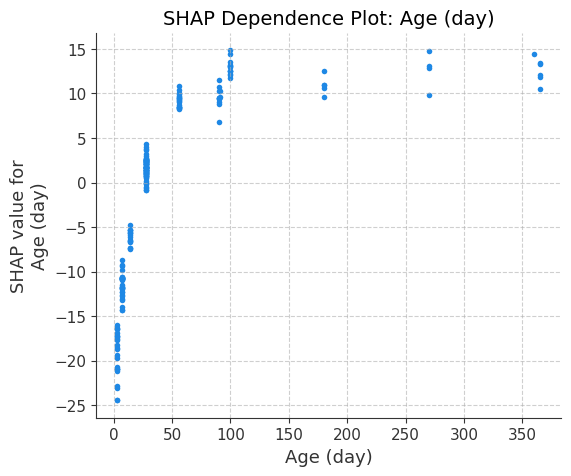

<Figure size 1000x600 with 0 Axes>

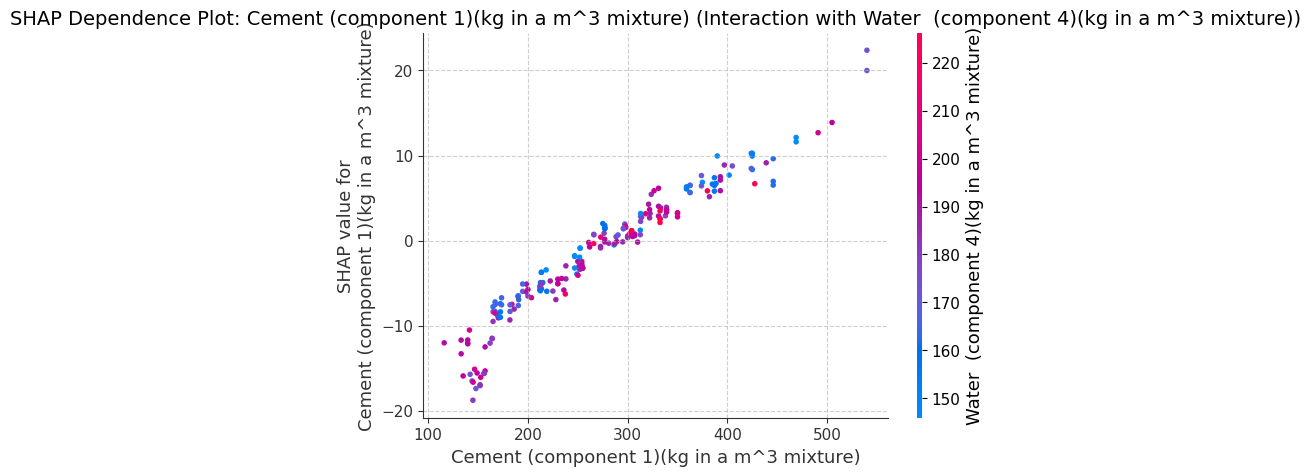

Plots generated successfully.


In [32]:
### **Python Code: SHAP Dependence Plots (Dependence Plots作成コード)**

import matplotlib.pyplot as plt
import shap

print("\n--- Generating SHAP Dependence Plots ---")

# 1. Re-calculate SHAP values using the BEST model
# 1. 最良モデル（best_xgb_model）を使用してSHAP値を再計算
# Note: X_test should be a DataFrame with proper column names for the plots to look good.
# 注意: きれいなプロットにするため，X_test は適切な列名を持つDataFrameである必要があります．

explainer = shap.Explainer(best_xgb_model, X_train)
shap_values = explainer(X_test)

# Get actual column names from X_test (or X, since they have same columns)
# X_testの正確なカラム名を取得します。
age_feature_name = X_test.columns[7]
cement_feature_name = X_test.columns[0]
water_feature_name = X_test.columns[3]

# ==========================================
# Plot A: Effect of Curing Age (材齢の影響)
# ==========================================
# Hypothesis: Strength should increase rapidly early on, then flatten (logarithmic curve).
# 仮説: 強度は初期に急激に増加し，その後横ばいになるはずです（対数曲線）．

plt.figure(figsize=(10, 6))
# "Age" is the column name. Interaction_index=None removes the color coding for clarity first.
# "Age" は列名です．interaction_index=None にすると，見やすくするために色分けを無効化します．
shap.dependence_plot(
    age_feature_name, # Use programmatically retrieved feature name
    shap_values.values,
    X_test,
    interaction_index=None,
    show=False
)
plt.title(f"SHAP Dependence Plot: {age_feature_name}", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


# ==========================================d
# Plot B: Effect of Cement with Interaction (セメントの影響と相互作用)
# ==========================================
# Hypothesis: More cement = more strength.
# Interaction: We color the dots by 'Water' to see the Water/Cement ratio effect.
# 仮説: セメントが多いほど強度は高くなる．
# 相互作用: 点を 'Water'（水）で色付けし，水セメント比の影響を確認します．

plt.figure(figsize=(10, 6))
shap.dependence_plot(
    cement_feature_name, # Use programmatically retrieved feature name
    shap_values.values,
    X_test,
    interaction_index=water_feature_name,  # Use programmatically retrieved interaction feature name
    show=False
)
plt.title(f"SHAP Dependence Plot: {cement_feature_name} (Interaction with {water_feature_name})", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("Plots generated successfully.")



### **3. Methodology (方法論)**

#### **3.1 Dataset Description (データセットの概要)**
**English:**
[cite_start]The dataset used in this study was obtained from the **UC Irvine Machine Learning Repository**, specifically the "Concrete Compressive Strength" dataset[cite: 48, 69]. [cite_start]This dataset contains **1,030 experimental samples**, which is sufficient to train robust machine learning models[cite: 30, 36].
[cite_start]The dataset consists of **eight input variables** representing the mix design and environmental conditions: Cement, Blast Furnace Slag, Fly Ash, Water, Superplasticizer, Coarse Aggregate, Fine Aggregate, and Age (curing time)[cite: 36]. The single output variable is **Concrete Compressive Strength (MPa)**.

**Japanese:**
[cite_start]本研究で使用したデータセットは，**UC Irvine Machine Learning Repository** の「Concrete Compressive Strength（コンクリート圧縮強度）」データセットから取得した [cite: 48, 69][cite_start]．このデータセットには **1,030件の実験サンプル** が含まれており，堅牢な機械学習モデルをトレーニングするのに十分な数である [cite: 30, 36]．
[cite_start]データセットは，配合設計および環境条件を表す **8つの入力変数**（セメント，高炉スラグ，フライアッシュ，水，高性能減水剤，粗骨材，細骨材，および材齢）で構成されている [cite: 36]．唯一の出力変数は **コンクリート圧縮強度 (MPa)** である．

#### **3.2 Data Preprocessing (データの前処理)**
**English:**
To ensure model stability and performance, the following preprocessing steps were applied:
1.  **Data Cleaning:** The dataset was inspected for missing values and outliers.
2.  **Normalization:** Input features were scaled using **StandardScaler** (zero mean and unit variance). [cite_start]This is particularly critical for models sensitive to feature magnitude, such as Artificial Neural Networks (ANN), although tree-based models are generally robust to unscaled data[cite: 49].
3.  **Data Splitting:** The data was randomly partitioned into a **training set (80%)** for model development and a **testing set (20%)** for unbiased evaluation.

**Japanese:**
モデルの安定性と性能を確保するために，以下の前処理ステップを適用した．
1.  **データのクリーニング:** データセット内の欠損値および外れ値の確認を行った．
2.  [cite_start]**正規化:** 入力特徴量は **StandardScaler**（平均0，分散1）を用いてスケーリングを行った．これは，決定木ベースのモデルはスケールされていないデータに対して一般的に堅牢であるものの，人工ニューラルネットワーク（ANN）のような特徴量の大きさに敏感なモデルにとっては特に重要である [cite: 49]．
3.  **データの分割:** モデル開発用の **トレーニングセット（80%）** と，バイアスのかかっていない評価を行うための **テストセット（20%）** にランダムに分割した．

#### **3.3 Machine Learning Algorithms (機械学習アルゴリズム)**
**English:**
This study implements an ensemble learning framework to overcome the limitations of single models. The following algorithms were selected based on the project objectives:
* [cite_start]**Baseline Models:** Linear Regression and Decision Trees were used to establish baseline performance benchmarks[cite: 29].
* **Random Forest (RF):** An ensemble method that constructs multiple decision trees during training. [cite_start]It reduces overfitting by averaging the results of individual trees[cite: 32].
* **XGBoost (Extreme Gradient Boosting):** A highly efficient implementation of gradient boosting. [cite_start]XGBoost was selected for its superior performance in handling non-linear relationships and its ability to achieve high predictive accuracy ($R^2 \ge 0.95$) as targeted in this project[cite: 49, 61].

**Japanese:**
本研究では，単一モデルの限界を克服するためにアンサンブル学習フレームワークを実装する．プロジェクトの目的に基づき，以下のアルゴリズムを選定した．
* [cite_start]**ベースラインモデル:** 性能のベンチマークを確立するために，線形回帰および決定木を使用した [cite: 29]．
* [cite_start]**ランダムフォレスト (RF):** トレーニング中に複数の決定木を構築するアンサンブル手法である．個々の木の予測結果を平均化することで，過学習を抑制する [cite: 32]．
* [cite_start]**XGBoost (Extreme Gradient Boosting):** 勾配ブースティングの高効率な実装である．非線形関係の処理における優れた性能と，本プロジェクトの目標である高い予測精度（$R^2 \ge 0.95$）を達成できる能力から，XGBoostを選定した [cite: 49, 61]．

#### **3.4 Hyperparameter Optimization (ハイパーパラメータの最適化)**
**English:**
[cite_start]To maximize model accuracy, **Grid Search** combined with **K-fold Cross-Validation** (k=5 or 10) was employed[cite: 30, 53]. This process systematically explored combinations of critical hyperparameters, such as `n_estimators` (number of trees), `learning_rate`, and `max_depth`. Cross-validation ensures that the model generalizes well to unseen data and is not overfitted to the training set.

**Japanese:**
[cite_start]モデルの精度を最大化するために，**グリッドサーチ（Grid Search）** と **K-分割交差検証（K-fold Cross-Validation）**（k=5 または 10）を組み合わせて採用した [cite: 30, 53]．このプロセスにより，`n_estimators`（木の数），`learning_rate`（学習率），`max_depth`（木の深さ）といった重要なハイパーパラメータの組み合わせを体系的に探索した．交差検証を行うことで，モデルが未知のデータに対して高い汎化性能を持ち，トレーニングセットに過学習していないことを保証する．

#### **3.5 Explainability Framework: SHAP (解釈可能性の枠組み: SHAP)**
**English:**
[cite_start]To address the "black-box" nature of ensemble models, **SHAP (SHapley Additive exPlanations)** analysis was integrated[cite: 40, 43]. Based on cooperative game theory, SHAP assigns an importance value to each feature for a particular prediction.
* [cite_start]**Global Interpretability:** SHAP summary plots were used to identify the most influential mix design parameters (e.g., Cement, Age)[cite: 50].
* [cite_start]**Local Interpretability & Interactions:** SHAP dependence plots were utilized to visualize non-linear relationships (e.g., strength gain over time) and interaction effects (e.g., Water-Cement Ratio synergy)[cite: 58].
[cite_start]This ensures the model provides not only accurate predictions but also engineering insights consistent with physical laws[cite: 16].

**Japanese:**
[cite_start]アンサンブルモデルの「ブラックボックス」的な性質に対処するため，**SHAP (SHapley Additive exPlanations)** 解析を統合した [cite: 40, 43]．協力ゲーム理論に基づく SHAP は，特定の予測に対する各特徴量の重要度を算出する．
* [cite_start]**全体的な解釈性:** SHAP summary plots を使用して，最も影響力のある配合パラメータ（例：セメント，材齢）を特定した [cite: 50]．
* [cite_start]**局所的な解釈性と相互作用:** SHAP dependence plots を使用して，非線形な関係（例：経時的な強度増進）や相互作用効果（例：水セメント比の相乗効果）を可視化した [cite: 58]．
[cite_start]これにより，モデルは正確な予測を提供するだけでなく，物理法則と整合した工学的洞察を提供することが保証される [cite: 16]．
